<a href="https://colab.research.google.com/github/chang-heekim/Implementation_Deep_Learning_Paper/blob/main/Generative%20Adversarial%20Networks/GAN_for_MNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image

from torchsummary import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 100

# Define GAN(Generator & Discriminator)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.LeakyReLU(0.2),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2),
        )
        self.layer4 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2),
        )
        self.layer5 = nn.Sequential(
            nn.Linear(1024, 1*28*28),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.layer1(z)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        g_img = self.layer5(x)
        g_img = g_img.view(g_img.size(0), 1, 28, 28)
        return g_img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(1*28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img = img.view(img.size(0), -1)
        out = self.layer(img)
        return out

# Load Mnist Dataset

In [ ]:
data_root = os.path.join(os.getcwd(), 'data')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = MNIST(root=data_root, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



# Set up Model & Optimizer & Loss

In [ ]:
epochs = 100
lr = 1e-3

generator = Generator().to(device)
summary(generator, (latent_dim,))

print()

discriminator = Discriminator().to(device)
summary(discriminator, (1, 28, 28))

adversarial_loss = nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          12,928
       BatchNorm1d-2                  [-1, 128]             256
         LeakyReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
       BatchNorm1d-5                  [-1, 256]             512
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
       BatchNorm1d-8                  [-1, 512]           1,024
         LeakyReLU-9                  [-1, 512]               0
           Linear-10                 [-1, 1024]         525,312
      BatchNorm1d-11                 [-1, 1024]           2,048
        LeakyReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 784]         803,600
             Tanh-14                  [

# Training

In [ ]:
for epoch in range(1, epochs + 1):
    for idx, (imgs, _) in enumerate(train_loader):
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

        real_images = imgs.to(device)

        # Training Generator
        optimizer_G.zero_grad()

        z = torch.normal(0, 1, (imgs.size(0), latent_dim)).to(device)

        g_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(g_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Training Discriminator
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_images), real)
        fake_loss = adversarial_loss(discriminator(g_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if idx % 100 == 0:
            save_image(real_images.data[:25], f'{idx}_real_images.png', nrow=5, normalize=True)
            save_image(g_imgs.data[:25], f'{idx}_generated.png', nrow=5, normalize=True)

    print(f'[Epoch {epoch} / {epochs}] G Loss: {g_loss.item():.6f}\tD Loss: {d_loss.item():.6f}')


[Epoch 1 / 100] G Loss: 1.032609	D Loss: 0.544186
[Epoch 2 / 100] G Loss: 0.979098	D Loss: 0.506250
[Epoch 3 / 100] G Loss: 2.890686	D Loss: 0.395493
[Epoch 4 / 100] G Loss: 0.948602	D Loss: 0.575177
[Epoch 5 / 100] G Loss: 1.723605	D Loss: 0.357991
[Epoch 6 / 100] G Loss: 1.797916	D Loss: 0.551128
[Epoch 7 / 100] G Loss: 1.464110	D Loss: 0.402296
[Epoch 8 / 100] G Loss: 0.971745	D Loss: 0.449478
[Epoch 9 / 100] G Loss: 1.379309	D Loss: 0.453919
[Epoch 10 / 100] G Loss: 1.226743	D Loss: 0.479311
[Epoch 11 / 100] G Loss: 1.423194	D Loss: 0.424996
[Epoch 12 / 100] G Loss: 1.573256	D Loss: 0.506573
[Epoch 13 / 100] G Loss: 1.296380	D Loss: 0.523577
[Epoch 14 / 100] G Loss: 0.951997	D Loss: 0.545022
[Epoch 15 / 100] G Loss: 1.835008	D Loss: 0.568069
[Epoch 16 / 100] G Loss: 1.771315	D Loss: 0.484784
[Epoch 17 / 100] G Loss: 1.569837	D Loss: 0.540242
[Epoch 18 / 100] G Loss: 1.177534	D Loss: 0.464503
[Epoch 19 / 100] G Loss: 1.355679	D Loss: 0.519938
[Epoch 20 / 100] G Loss: 1.012001	D Loss

# Visualization Real images & Generated images

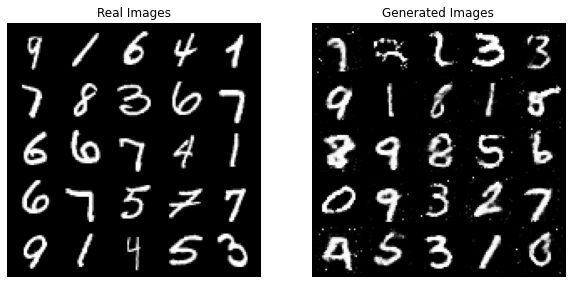

In [ ]:
fake_img = Image.open('/content/400_generated.png')
fake_img = np.array(fake_img)

real_img = Image.open('/content/400_real_images.png')
real_img = np.array(real_img)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(real_img)
plt.axis('off')
plt.title('Real Images')

plt.subplot(122)
plt.imshow(fake_img)
plt.axis('off')
plt.title('Generated Images')
plt.show()